In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import *

In [2]:
train = pd.read_csv("../data/TRAIN.csv")
y_train = train["SEPSIS"]
X_train = train.drop("SEPSIS", axis=1)

In [3]:
test = pd.read_csv("../data/TEST.csv")
y_test = test["SEPSIS"]
X_test = test.drop("SEPSIS", axis=1)

# Helper Function

In [4]:
def classification_metrics(Y_pred, Y_true, Y_score):
    #NOTE: It is important to provide the output in the same order
    acc = accuracy_score(Y_true,Y_pred)
    bacc = balanced_accuracy_score(Y_true, Y_pred)
    auc_ = roc_auc_score(Y_true,Y_score)
    precision = precision_score(Y_true,Y_pred)
    recall = recall_score(Y_true,Y_pred)
    f1score = f1_score(Y_true,Y_pred)
    return acc, bacc, auc_, precision, recall, f1score

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalize
    cmap = plt.cm.Blues

    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           title="Normalized Confusion Matrix",
           ylabel='True', xlabel='Predicted')

    # Rotate the tick labels and set alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f'
    thresh = cm.max() / 2.
    # Loop over data dimensions and create text annotations
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    plt.show()

# Parameter tuning & CV (w/o resampling)
### Logistic Regression

In [6]:
from sklearn.model_selection import GridSearchCV

In [7]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

In [8]:
glm_para = {'penalty':('l1', 'l2'), 'C':[0.1, 1, 10]}
glm = LogisticRegression(random_state=42, class_weight='balanced')
clf = GridSearchCV(glm, glm_para, cv=5, scoring="f1")
clf.fit(X_train, y_train)

/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=42,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'penalty': ('l1', 'l2'), 'C': [0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [9]:
print(clf.best_params_)
print("Best score: {}".format(clf.best_score_))

{'C': 1, 'penalty': 'l2'}
Best score: 0.397831170046313


In [10]:
glm = LogisticRegression(random_state=0, class_weight="balanced").fit(X_train, y_train)
y_pred_lr = glm.predict(X_test)
y_score_lr = glm.predict_proba(X_test)[:,1]

/anaconda3/envs/sepsis/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


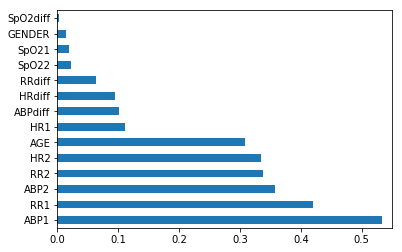

In [11]:
feat_imp = pd.Series(np.std(X_train, 0)*abs(glm.coef_.reshape(14)), index = X_train.columns)
feat_imp.nlargest(14).plot(kind="barh")
plt.xlim(0, 0.55)
plt.show()

In [12]:
acclr, bacclr, auclr, prelr, reclr, f1lr = classification_metrics(y_pred_lr, y_test, y_score_lr)
print(classification_metrics(y_pred_lr, y_test, y_score_lr))

(0.7690721649484537, 0.7551032956222331, 0.8173061157566814, 0.302158273381295, 0.7368421052631579, 0.4285714285714286)


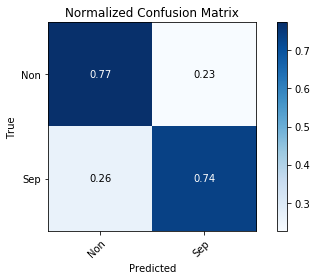

In [13]:
plot_confusion_matrix(y_test, y_pred_lr, ["Non","Sep"])

### Random Forest

In [14]:
rf_para = {'n_estimators':(100, 150, 200, 250), 'max_depth':(5,10)}
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
clf = GridSearchCV(rf, rf_para, cv=5, scoring="f1")
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': (100, 150, 200, 250), 'max_depth': (5, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [15]:
print(clf.best_params_)
print("Best score: {}".format(clf.best_score_))

{'max_depth': 5, 'n_estimators': 200}
Best score: 0.43525470530926114


In [16]:
rf = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=5, class_weight="balanced")
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_score_rf = rf.predict_proba(X_test)[:,1]

In [17]:
accrf, baccrf, aucrf, prerf, recrf, f1rf = classification_metrics(y_pred_rf, y_test, y_score_rf)
print(classification_metrics(y_pred_rf, y_test, y_score_rf))

(0.8391752577319588, 0.6959747499590097, 0.8439088375143465, 0.3670886075949367, 0.5087719298245614, 0.42647058823529416)


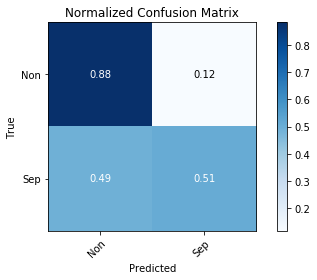

In [18]:
plot_confusion_matrix(y_test, y_pred_rf, ["Non","Sep"])

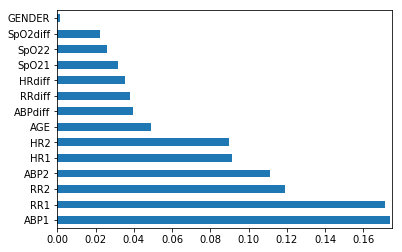

In [20]:
feat_imp = pd.Series(rf.feature_importances_, index = X_train.columns)
feat_imp.nlargest(14).plot(kind="barh")
plt.xlim(0, 0.175)
plt.show()

### SVM

In [21]:
from sklearn.svm import SVC

In [ ]:
svm_para = {'kernel':("linear","rbf","sigmoid"), 'gamma':('auto','scale')}
svm = SVC(class_weight="balanced", probability=True)
clf = GridSearchCV(svm, svm_para, cv=5, scoring="f1")
clf.fit(X_train, y_train)

In [ ]:
print(clf.best_params_)
print("Best score: {}".format(clf.best_score_))

In [22]:
svm = SVC(kernel="linear",gamma="auto",class_weight="balanced",probability=True)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
y_score_svm = svm.predict_proba(X_test)[:,1]

In [23]:
accsvm, baccsvm, aucsvm, presvm, recsvm, f1svm = classification_metrics(y_pred_svm, y_test, y_score_svm)
print(classification_metrics(y_pred_svm, y_test, y_score_svm))

(0.7628865979381443, 0.7592023282505329, 0.8192736514182652, 0.2986111111111111, 0.7543859649122807, 0.42786069651741293)


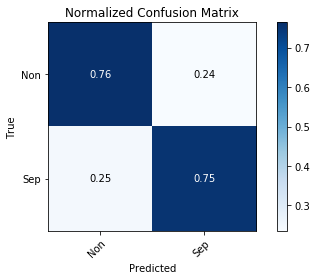

In [24]:
plot_confusion_matrix(y_test, y_pred_svm, ["Non","Sep"])

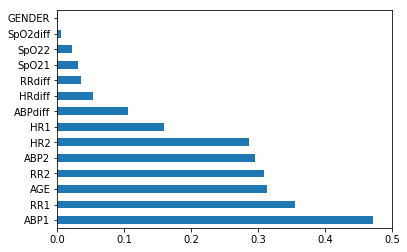

In [25]:
feat_imp = pd.Series(np.std(X_train, 0)*abs(svm.coef_.reshape(14)), index = X_train.columns)
feat_imp.nlargest(14).plot(kind="barh")
plt.xlim(0, 0.5)
plt.show()

# Tuning & CV (With Resampling)

In [26]:
train_1 = train[train["SEPSIS"]==1]
train_0 = train[train["SEPSIS"]==0]

In [27]:
len(train_1)

216

In [28]:
train_balance = pd.concat([train_0.sample(300, random_state=777), train_1])

In [30]:
X_train_b = train_balance.drop(["SEPSIS"], axis=1)
y_train_b = train_balance["SEPSIS"]

# Gradient Boosting

In [50]:
from sklearn.ensemble import GradientBoostingClassifier
gbt_para = {'n_estimators':(50,100,200), 'max_depth':[1,3,5]}
gbt = GradientBoostingClassifier(learning_rate=0.1, random_state=42)
clfgbt = GridSearchCV(gbt, gbt_para, cv=5, scoring="f1")
clfgbt.fit(X_train_b, y_train_b)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': (50, 100, 200), 'max_depth': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [51]:
print(clfgbt.best_params_)
print("Best score: {}".format(clfgbt.best_score_))

{'max_depth': 5, 'n_estimators': 100}
Best score: 0.6982987578983768


In [54]:
gbt = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42).fit(X_train_b, y_train_b)
y_pred_gbt = clfgbt.predict(X_test)
y_score_gbt = clfgbt.predict_proba(X_test)[:,1]
accgbt, baccgbt, aucgbt, pregbt, recgbt, f1gbt = classification_metrics(y_pred_gbt, y_test, y_score_gbt)

In [55]:
print(classification_metrics(y_pred_gbt, y_test, y_score_gbt))

(0.8020618556701031, 0.728172651254304, 0.7972618462042959, 0.32432432432432434, 0.631578947368421, 0.42857142857142855)


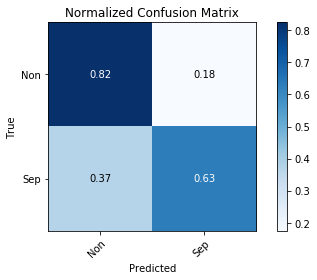

In [56]:
plot_confusion_matrix(y_test, y_pred_gbt, ["Non","Sep"])

# AdaBoost

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
abt_para = {'n_estimators':(50,100,200)}
abt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5, random_state=42, class_weight="balanced"), random_state=42)
clfabt = GridSearchCV(abt, abt_para, cv=5, scoring="f1")
clfabt.fit(X_train_b, y_train_b)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=42),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': (50, 100, 200)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [58]:
print(clfabt.best_params_)
print("Best score: {}".format(clfabt.best_score_))

{'n_estimators': 200}
Best score: 0.6732563846929309


In [59]:
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5, random_state=42, class_weight="balanced"), n_estimators=200, random_state=42)
bdt.fit(X_train_b, y_train_b)
y_pred_ab = clfabt.predict(X_test)
y_score_ab = clfabt.predict_proba(X_test)[:,1]

In [60]:
accab, baccab, aucab, preab, recab, f1ab = classification_metrics(y_pred_ab, y_test, y_score_ab)
print(classification_metrics(y_pred_ab, y_test, y_score_ab))

(0.8123711340206186, 0.772032300377111, 0.8403426791277259, 0.35344827586206895, 0.7192982456140351, 0.47398843930635837)


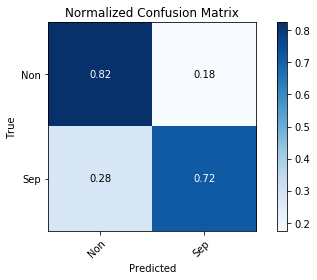

In [61]:
plot_confusion_matrix(y_test, y_pred_ab, ["Non","Sep"])

# Random Forest

In [62]:
rf_para = {'n_estimators':(100, 150, 200, 250), 'max_depth':(5,10)}
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
clfrf = GridSearchCV(rf, rf_para, cv=5, scoring="f1")
clfrf.fit(X_train_b, y_train_b)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=None, oob_score=False,
            random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': (100, 150, 200, 250), 'max_depth': (5, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [63]:
print(clf.best_params_)
print("Best score: {}".format(clf.best_score_))

{'max_depth': 5, 'n_estimators': 200}
Best score: 0.7046669784675117


In [64]:
#class_weight="balanced"
rf2 = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=5)
rf2.fit(X_train_b, y_train_b)
y_pred_rf2 = clfrf.predict(X_test)
y_score_rf2 = clfrf.predict_proba(X_test)[:,1]

In [65]:
accrf2, baccrf2, aucrf2, prerf2, recrf2, f1rf2 = classification_metrics(y_pred_rf2, y_test, y_score_rf2)
print(classification_metrics(y_pred_rf2, y_test, y_score_rf2))

(0.8164948453608247, 0.7895761600262339, 0.8537875061485489, 0.3644067796610169, 0.7543859649122807, 0.49142857142857144)


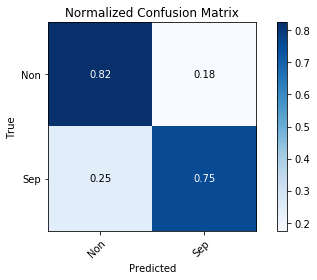

In [66]:
plot_confusion_matrix(y_test, y_pred_rf2, ["Non","Sep"])

### Niche models (Gaussian Bayes, k-NN)

In [67]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_b, y_train_b)
y_pred_nb = gnb.predict(X_test)
y_score_nb = gnb.predict_proba(X_test)[:,1]

In [68]:
accnb, baccnb, aucnb, prenb, recnb, f1nb = classification_metrics(y_pred_nb, y_test, y_score_nb)
print(classification_metrics(y_pred_nb, y_test, y_score_nb))

(0.7876288659793814, 0.7047876701098541, 0.8169372028201345, 0.2982456140350877, 0.5964912280701754, 0.39766081871345027)


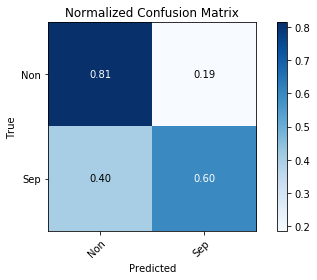

In [69]:
plot_confusion_matrix(y_test, y_pred_nb, ["Non","Sep"])

In [70]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X_train_b, y_train_b)
y_pred_kn = neigh.predict(X_test)
y_score_kn = neigh.predict_proba(X_test)[:,1]

In [71]:
acckn, bacckn, auckn, prekn, reckn, f1kn = classification_metrics(y_pred_kn, y_test, y_score_kn)
print(classification_metrics(y_pred_kn, y_test, y_score_kn))

(0.7422680412371134, 0.6790867355304149, 0.7319437612723398, 0.25, 0.5964912280701754, 0.35233160621761656)


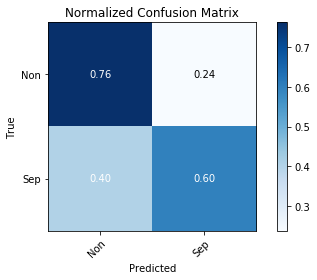

In [72]:
plot_confusion_matrix(y_test, y_pred_kn, ["Non","Sep"])

In [73]:
fprsvm, tprsvm, thresholdssvm = roc_curve(y_test, y_score_svm, pos_label=1)
fprlr, tprlr, thresholdslr = roc_curve(y_test, y_score_lr, pos_label=1)
fprab, tprab, thresholdsab = roc_curve(y_test, y_score_ab, pos_label=1)
fprgb, tprgb, thresholdsgb = roc_curve(y_test, y_score_gbt, pos_label=1)
fprkn, tprkn, thresholdskn = roc_curve(y_test, y_score_kn, pos_label=1)
fprnb, tprnb, thresholdsnb = roc_curve(y_test, y_score_nb, pos_label=1)
fprrf, tprrf, thresholdsrf = roc_curve(y_test, y_score_rf2, pos_label=1)

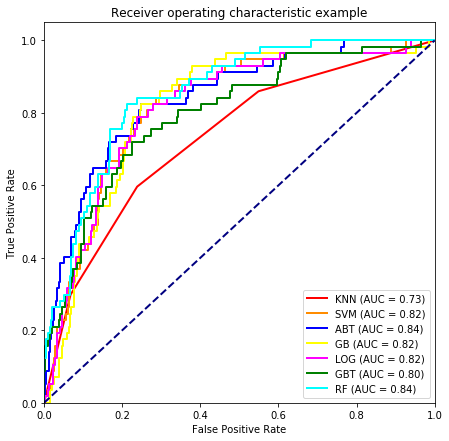

In [74]:
plt.figure(figsize=(7,7))
lw = 2
plt.plot(fprkn, tprkn, color='red',
         lw=lw, label='KNN (AUC = %0.2f)' % auckn)
plt.plot(fprsvm, tprsvm, color='darkorange',
         lw=lw, label='SVM (AUC = %0.2f)' % aucsvm)
plt.plot(fprab, tprab, color='blue',
         lw=lw, label='ABT (AUC = %0.2f)' % aucab)
plt.plot(fprnb, tprnb, color='yellow',
         lw=lw, label='GB (AUC = %0.2f)' % aucnb)
plt.plot(fprlr, tprlr, color='magenta',
         lw=lw, label='LOG (AUC = %0.2f)' % auclr)
plt.plot(fprgb, tprgb, color='green',
         lw=lw, label='GBT (AUC = %0.2f)' % aucgbt)
plt.plot(fprrf, tprrf, color='cyan',
         lw=lw, label='RF (AUC = %0.2f)' % aucrf)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Save model

In [86]:
from joblib import dump, load
dump(svm, '../model/svm.joblib') 
dump(clfabt, '../model/abt.joblib') 
dump(glm, '../model/glm.joblib') 
dump(clfrf, '../model/rf.joblib') 

['../model/rf.joblib']

# Feature Importance

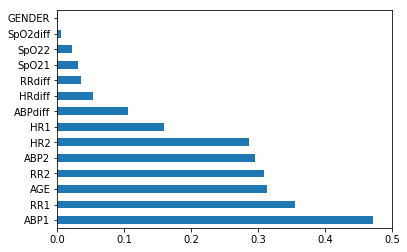

In [77]:
#SVM
feat_imp = pd.Series(np.std(X_train, 0)*abs(svm.coef_.reshape(14)), index = X_train.columns)
feat_imp.nlargest(14).plot(kind="barh")
plt.xlim(0, 0.5)
plt.show()

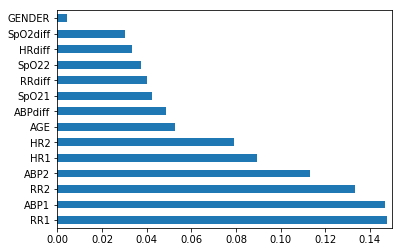

In [80]:
# RF
feat_imp = pd.Series(clfrf.best_estimator_.feature_importances_, index = X_train.columns)
feat_imp.nlargest(14).plot(kind="barh")
plt.xlim(0, 0.15)
plt.show()

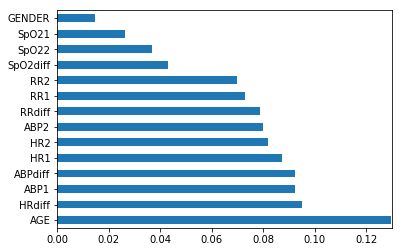

In [81]:
# ABT
feat_imp = pd.Series(clfabt.best_estimator_.feature_importances_, index = X_train.columns)
feat_imp.nlargest(14).plot(kind="barh")
plt.xlim(0, 0.13)
plt.show()

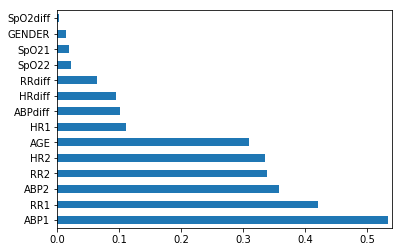

In [91]:
# GLM
feat_imp = pd.Series(np.std(X_train, 0)*abs(glm.coef_.reshape(14)), index = X_train.columns)
feat_imp.nlargest(14).plot(kind="barh")
plt.xlim(0, 0.54)
plt.show()